# MRI Synthesis

In this notebook, we will use transforms that generate synthetic MRIs with varying contrast and resolution from label maps.

This is a reimplementation of the domain randomization approach described in:

Billot, B., Greve, D.N., Puonti, O., Thielscher, A., Van Leemput, K., Fischl, B., Dalca, A.V. and Iglesias, J.E., 2023.
[**SynthSeg: Segmentation of brain MRI scans of any contrast and resolution without retraining.**](https://www.sciencedirect.com/science/article/pii/S1361841523000506)
_Medical image analysis_, 86, p.102789.

        @article{billot2023synthseg,
          title     = {SynthSeg: Segmentation of brain MRI scans of any contrast and resolution without retraining},
          author    = {Billot, Benjamin and Greve, Douglas N and Puonti, Oula and Thielscher, Axel and Van Leemput, Koen and Fischl, Bruce and Dalca, Adrian V and Iglesias, Juan Eugenio and others},
          journal   = {Medical image analysis},
          volume    = {86},
          pages     = {102789},
          year      = {2023},
          publisher = {Elsevier},
          url       = {https://www.sciencedirect.com/science/article/pii/S1361841523000506}
        }

In [1]:
!pushd $TMPDIR \
    && wget https://github.com/BBillot/SynthSeg/raw/master/data/training_label_maps/training_seg_01.nii.gz \
    -O demo.nii.gz \
    && popd

/home/scratch /autofs/space/pade_001/users/yb947/code/yb/cornucopia/docs/examples
--2023-08-16 19:27:37--  https://github.com/BBillot/SynthSeg/raw/master/data/training_label_maps/training_seg_01.nii.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BBillot/SynthSeg/master/data/training_label_maps/training_seg_01.nii.gz [following]
--2023-08-16 19:27:38--  https://raw.githubusercontent.com/BBillot/SynthSeg/master/data/training_label_maps/training_seg_01.nii.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1662924 (1.6M) [application/octet-stream]
Saving to: ‘demo.nii.gz’

demo.nii.gz         1

In [2]:
import torch
import os
import matplotlib.pyplot as plt
from cornucopia import (
    LoadTransform, RelabelTransform,
    IntensityTransform, SynthFromLabelTransform, RandomGaussianMixtureTransform)

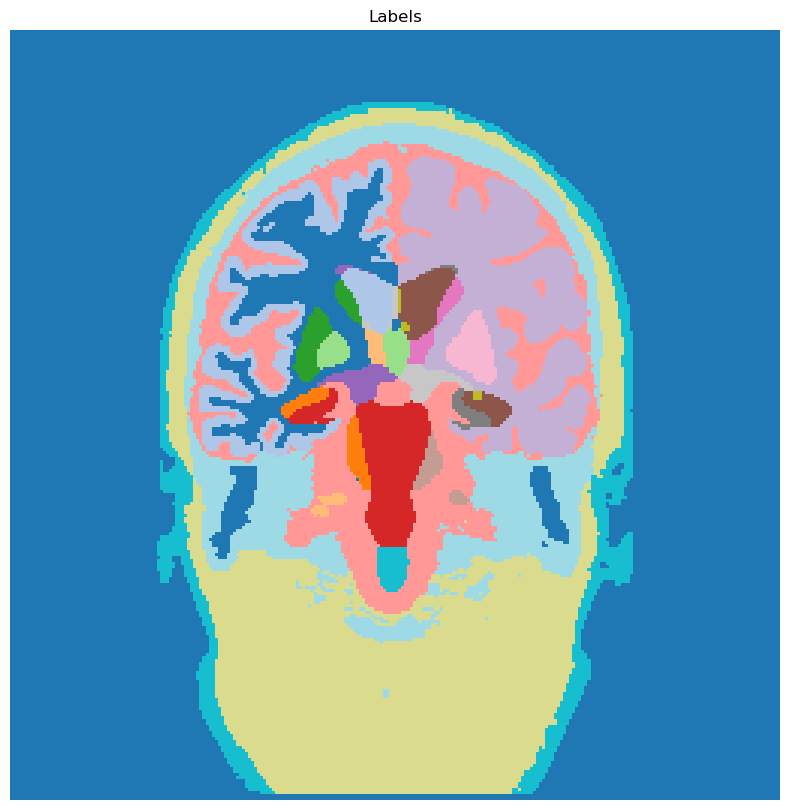

In [3]:
fname = os.path.join(os.environ['TMPDIR'], 'demo.nii.gz')
lab = LoadTransform(dtype=torch.int)(fname)
lab = lab[:, :, lab.shape[-2]//2, :]
lab = RelabelTransform()(lab)

plt.figure(figsize=(10, 10))
plt.imshow(lab[0].T.flip(0), cmap='tab20', interpolation='nearest')
plt.axis('off')
plt.title('Labels')
plt.show()

Then, instantiate a `IntensityTransform` and apply it to our labels.
Note that tensors fed to a `Transform` layer should have a channel dimension, and no batch dimension.

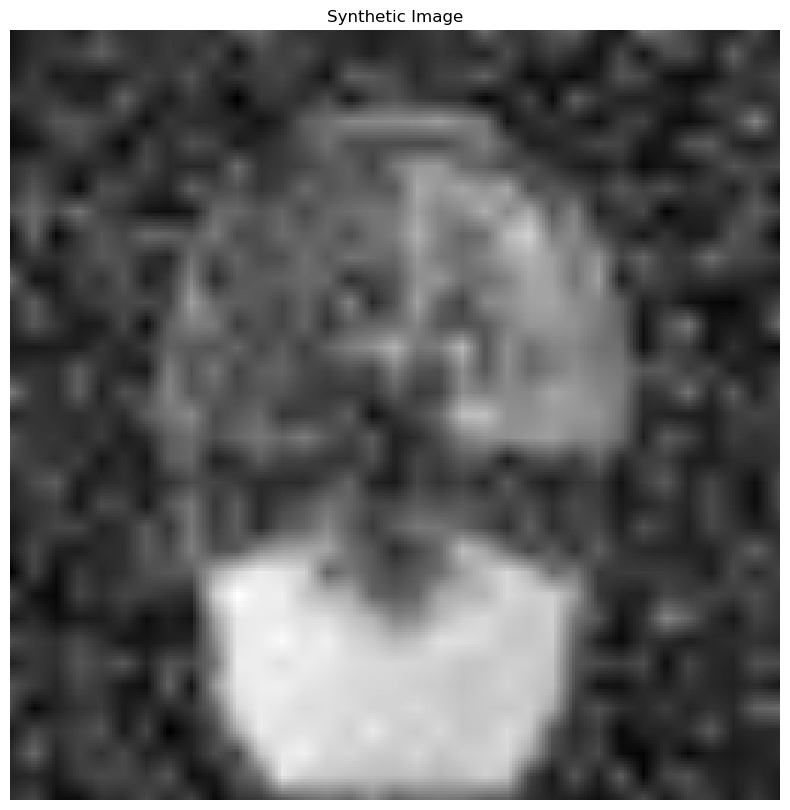

In [4]:
trf = RandomGaussianMixtureTransform(background=0) + IntensityTransform()
img = trf(lab)

plt.figure(figsize=(10, 10))
plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Synthetic Image')
plt.show()

Now, let's synthesize a bunch of them

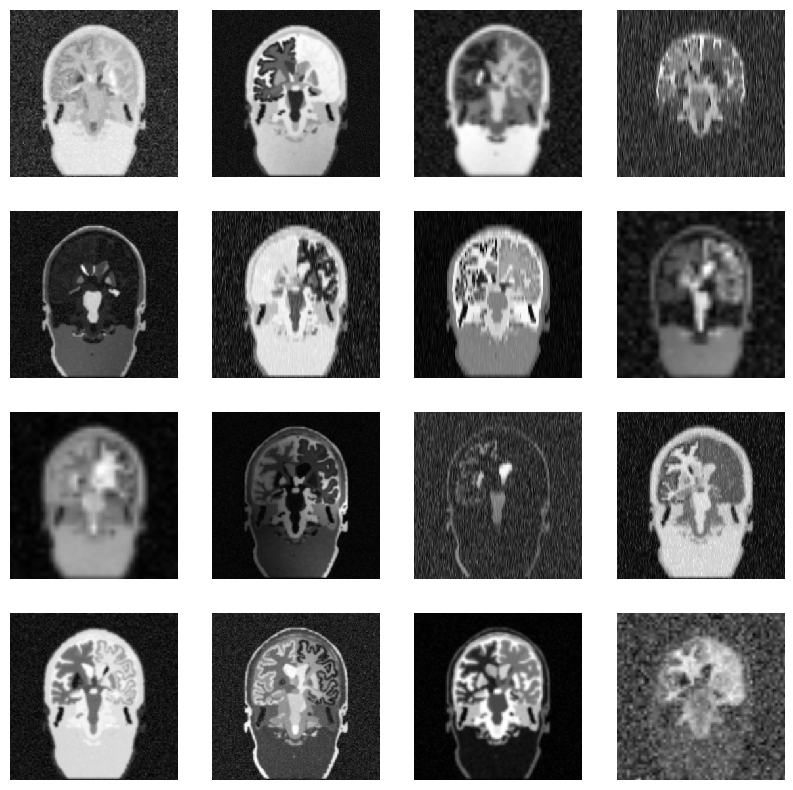

In [5]:
shape = [4, 4]
plt.figure(figsize=(10, 10))

for i in range(shape[0] * shape[1]):
    plt.subplot(*shape, i+1)
    plt.imshow(trf(lab).squeeze().T.flip(0), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()

Finally, let's try the full pipeline with deformations

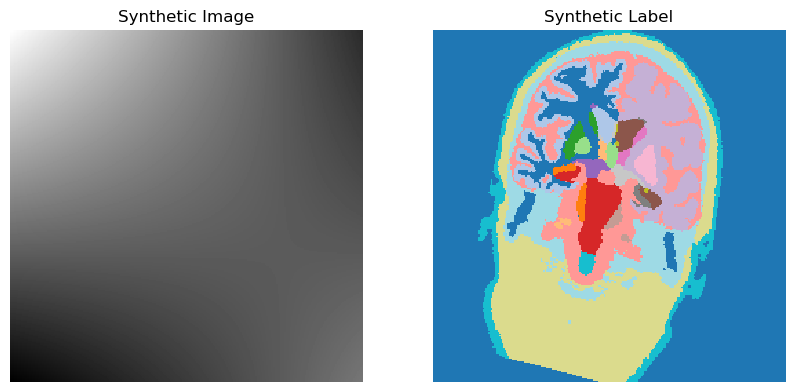

In [16]:
trf = SynthFromLabelTransform(bias=False, snr=1000, gamma=False)
img, newlab = trf(lab)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Synthetic Image')
plt.subplot(1, 2, 2)
plt.imshow(newlab.squeeze().T.flip(0), cmap='tab20', interpolation='nearest')
plt.axis('off')
plt.title('Synthetic Label')
plt.show()

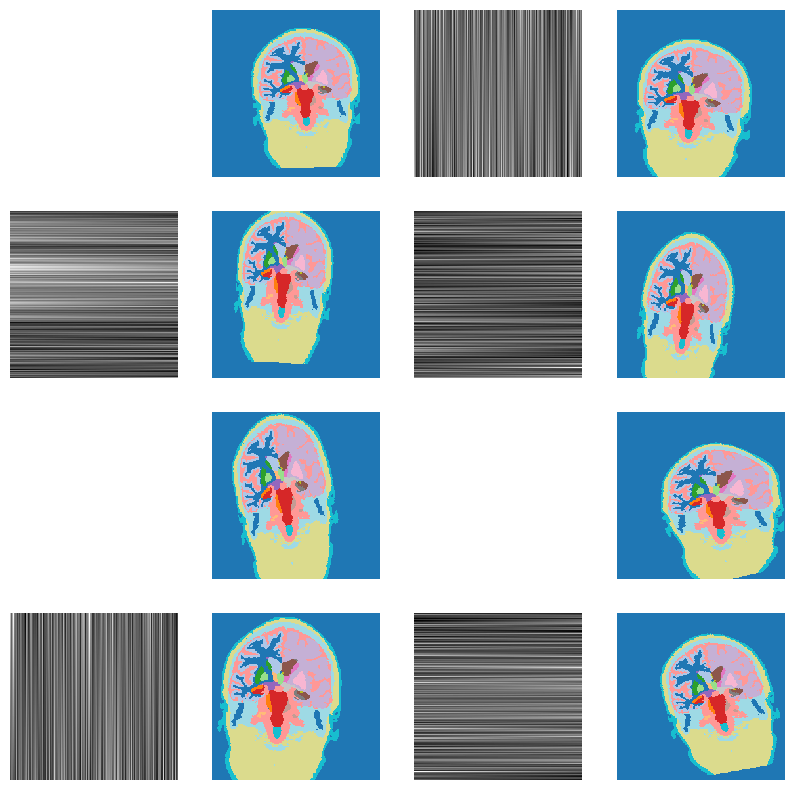

In [17]:
shape = [4, 4]
plt.figure(figsize=(10, 10))

for i in range(shape[0] * shape[1]//2):
    img, newlab = trf(lab)
    plt.subplot(*shape, 2*i+1)
    plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(*shape, 2*i+2)
    plt.imshow(newlab.squeeze().T.flip(0), cmap='tab20', interpolation='nearest')
    plt.axis('off')
plt.show()
